In [1]:
import cv2
import os
import sys
import random
import glob
import keras
import math

import numpy as np
from numpy import argmax
from keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation,Flatten,Dropout,Dense

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from imutils import paths
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121

from keras.layers import Conv2D, GlobalAveragePooling1D, AveragePooling2D, AveragePooling1D, AveragePooling3D, GlobalAveragePooling2D, GlobalAveragePooling3D



Using TensorFlow backend.


In [2]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [3]:
import glob
files = glob.glob("/home/cudacenter/BE/New_Chest_Xray/train/normal/*.*")

import cv2
cv_img1 = []
for file in files:
    image= cv2.imread(file)
    image=cv2.resize(image,(75,75))
    cv_img1.append(image)
len(cv_img1)

1341

In [4]:
import glob
files = glob.glob("/home/cudacenter/BE/New_Chest_Xray/train/pneumonia/*.*")

import cv2

for file in files:
    image= cv2.imread(file)
    image=cv2.resize(image,(75,75))
    cv_img1.append(image)
len(cv_img1)

5216

In [5]:
ytrain=np.empty((0,2),int)
a1=np.array([1,0.0])
a1=np.expand_dims(a1,axis=0)
a2=np.array([0,1.0])
a2=np.expand_dims(a2,axis=0)

for i in range(1341):
    ytrain=np.append(ytrain,a1,axis=0)
    
for i in range(3875):
    ytrain=np.append(ytrain,a2,axis=0) 

In [6]:
print(len(ytrain))

5216


In [7]:
ytrain.shape

(5216, 2)

In [8]:
import glob
files = glob.glob("/home/cudacenter/BE/New_Chest_Xray/test/normal/*.*")
import cv2
cv_img2 = []
for file in files:
    image= cv2.imread(file)
    image=cv2.resize(image,(75,75))
    cv_img2.append(image)
len(cv_img2)

234

In [9]:
files = glob.glob("/home/cudacenter/BE/New_Chest_Xray/test/pneumonia/*.*")

import cv2

for file in files:
    image= cv2.imread(file)
    image=cv2.resize(image,(75,75))
    cv_img2.append(image)
len(cv_img2)

624

In [10]:
ytest=np.empty((0,2),int)
a1=np.array([1,0.0])
a1=np.expand_dims(a1,axis=0)
a2=np.array([0,1.0])
a2=np.expand_dims(a2,axis=0)

for i in range(234):
    ytest=np.append(ytest,a1,axis=0)
    
for i in range(390):
    ytest=np.append(ytest,a2,axis=0) 

In [11]:
print(len(ytest))

624


In [12]:
cv_img1=np.array(cv_img1)
cv_img2=np.array(cv_img2)

cv_img1 = cv_img1.astype('float32')
cv_img2 = cv_img2.astype('float32')
#val_images=np.array(val_images)

In [13]:
cv_img1=cv_img1/255
cv_img2=cv_img2/255

data_train,data_val,labels_train,labels_val=train_test_split(cv_img1,ytrain,test_size=0.2, random_state=42)

In [14]:
def step_decay(epoch):
    initial_lrate=0.001
    drop=0.1
    epochs_drop=10
    lrate=initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate
'''
    lrate = initial_lrate
    if (epoch == 10) :
        lrate = 0.00001
    elif (epoch == 20) :
        lrate = 0.000001
    elif (epoch == 30) :
        lrate = 0.0000001
'''

'\n    lrate = initial_lrate\n    if (epoch == 10) :\n        lrate = 0.00001\n    elif (epoch == 20) :\n        lrate = 0.000001\n    elif (epoch == 30) :\n        lrate = 0.0000001\n'

In [15]:
base_model = DenseNet121(include_top=True, weights=None,input_shape=(75,75,3),classes=14)
base_model.load_weights('/home/cudacenter/BE/New_Chest_Xray/Chexnet weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5') 


x = base_model.output
# x = GlobalAveragePooling1D()(x)

# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)
y = Dropout(0.3)(x)

# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(y)

model = Model(inputs=base_model.input, outputs=predictions)

print(base_model.input)
model.summary()

Tensor("input_1:0", shape=(?, 75, 75, 3), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 81, 81, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 38, 38, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1/conv[0][0]                 
____________________________________________________

In [16]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=1e-04, decay = 1e-02),metrics=['accuracy'])

In [17]:
lr=keras.callbacks.LearningRateScheduler(step_decay,verbose=1)
    
# This will do preprocessing and realtime data augmentation:
tbCallback=keras.callbacks.TensorBoard(log_dir='./Logs/Tensorboard_Logs', histogram_freq=0, 
                                           batch_size=16, write_graph=False, write_grads=False, 
                                           write_images=False, embeddings_freq=0, embeddings_layer_names=None, 
                                           embeddings_metadata=None)
checkpoint=keras.callbacks.ModelCheckpoint('./Logs/Checkpoint', monitor='val_loss', 
                                               verbose=0, save_best_only=True, 
                                               save_weights_only=False, 
                                               mode='auto',
                                               period=1)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(data_train)
    # Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(datagen.flow(data_train,labels_train,batch_size=8),steps_per_epoch=25,epochs=20, validation_data=(data_val,labels_val),workers=4,callbacks=[tbCallback, checkpoint,lr])

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
25/25 [==============================] - 28s 1s/step - loss: 0.6427 - acc: 0.6800 - val_loss: 0.5880 - val_acc: 0.7241
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
25/25 [==============================] - 6s 248ms/step - loss: 0.5597 - acc: 0.7750 - val_loss: 0.5437 - val_acc: 0.7251
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
25/25 [==============================] - 6s 237ms/step - loss: 0.5325 - acc: 0.7450 - val_loss: 0.5565 - val_acc: 0.7241
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
25/25 [==============================] - 6s 232ms/step - loss: 0.5193 - acc: 0.7350 - val_loss: 0.5290 - val_acc: 0.7241
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
25/25 [==============================] - 6s 236ms/step - loss: 0.4952 - acc: 0.7450 - val_loss: 0.5296 - val_acc: 0.7251
Ep

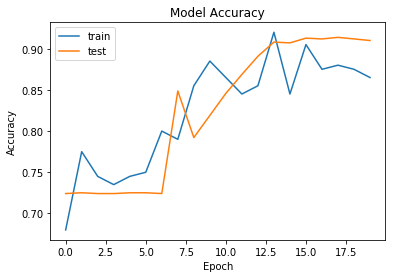

In [18]:
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','test'],loc='best')
plt.show
plt.savefig('Comparision.png')

In [19]:
import itertools
score=model.evaluate(cv_img2,ytest,verbose=1)
print(score[0])
print(score[1])

624/624 [==============================] - 1s 2ms/step
0.43035589769864696
0.8910256410256411


In [20]:
model.save('model_Dense_89.h5')

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
import itertools
score=model.evaluate(cv_img2,ytest,verbose=2)
print(score[0])
print(score[1])
cm=confusion_matrix(np.argmax(ytest,axis=1), np.argmax(model.predict(cv_img2),axis=1))

0.43035589769864696
0.8910256410256411


Confusion matrix, without normalization
[[189  45]
 [ 23 367]]


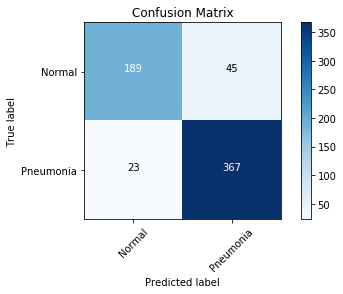

In [24]:
cm_plot_labels=["Normal","Pneumonia"]
plot_confusion_matrix(cm,cm_plot_labels,title="Confusion Matrix")
plt.savefig('Confusion.eps')